# Esercitazione 1: Lexical Overlapping

Misurazione dell’overlap lessicale tra una serie di definizioni per concetti generici/specifici e concreti/astratti. Partendo dai dati sulle definizioni (presente nella cartella "dati" su Moodle), si richiede di calcolare la similarità 2-a-2 tra le definizioni (ad es. usando la cardinalità dell'intersezione dei lemmi normalizzata sulla lunghezza minima delle definizioni), aggregando (ed effettuando la media degli score di similarità) sulle due dimensioni (concretezza / specificità). 

In [1]:
# Dipendenze
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from statistics import mean
from itertools import combinations, starmap
import pandas as pd

### Data Loading

Caricamento del dataset di definizioni relative ai concetti usando la libreria pandas


In [2]:
file_path = './TLN-definitions-23.tsv'

defs_df = pd.read_csv(file_path, sep='\t')

# Rimuovo la prima colonna siccome non la utilizzerò
defs_df = defs_df[defs_df.columns[1:]]
# Rinomino le colonne, appendendo le seguenti stringhe
new_col_names = ['concreto_generico', 'concreto_specifico',
                 'astratto_generico', 'astratto_specifico']
# aggiungo come preffissi le seguenti stringhe in new_col_names
defs_df.columns = list(
    map(lambda x: x[0] + '_' + x[1], zip(new_col_names, defs_df.columns)))

Visualizziamo le prime 10 definizioni per i 4 concetti presenti:

- _door_ (concreto-generico)
- _ladybug_ (concreto-specifico)
- _pain_ (astratto-generico)
- _blurriness_ (astratto-specifico)


In [3]:
defs_df_ex = defs_df.iloc[:4, :]
(defs_df_ex.head(10))

,concreto_generico_door,concreto_specifico_ladybug,astratto_generico_pain,astratto_specifico_blurriness
0,"A construction used to divide two rooms, tempo...","small flying insect, typically red with black ...",A feeling of physical or mental distress,sight out of focus
1,"It's an opening, it can be opened or closed.","It is an insect, it has wings, red with black ...","It is a feeling, physical or emotional. It is ...","It is the absence of definite borders, shapele..."
2,"An object that divide two room, closing an hol...",An insect that can fly. It has red or orange c...,A felling that couscious beings can experince ...,A sensation felt when you can't see clearly th...
3,Usable for access from one area to another,Small insect with a red back,Concept that describes a suffering living being,Lack of sharpness


Per completare il compito, dobbiamo valutare quanto le diverse definizioni di ogni concetto siano simili. Seguiamo questi passaggi principali:

1. Scelta della rappresentazione computazionale per le definizioni, quindi Bag-of-words
2. Effettuiamo il preprocessing.
3. Calcoliamo la media della similarità tra tutte le possibili combinazioni di coppie di definizioni, usando l'overlap.
4. Visualizziamo i risultati.


### Preprocessing e rappresentazione

La rappresentazione Bag-of-Words è un modo semplice di rappresentare una frase in cui vengono ignorate le informazioni sulla struttura grammaticale e vengono considerate solo le occorrenze delle parole.

Siccome il concetto di similarità è relativo al numero totale di termini che matchano tra le definizioni, considererò le implicazioni
relative al **mantenere o rimuovere le function words**.


In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

additional_stopwords = ['\'s', '’']
lemmatizer = WordNetLemmatizer()
stopwordset = set(stopwords.words('english') + additional_stopwords)
def to_lower_case(words):
    return words.lower()

def tokenize(sentence):
    return nltk.word_tokenize(sentence)

def lemmatize(words):
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word.lower())  # Specify the part-of-speech tag 'v' for verb
        lemmas.append(lemma)
    return lemmas


def remove_stopwords(words):
    return [word for word in words if word not in stopwordset]

def remove_punctuation(words):
    return [word for word in words if word not in punctuation]

def filter_contained_in_wd(words):
    return {x for x in words if len(wn.synsets(x)) > 0}

def lemmatized_tokens(text, handle_stop_words=True):
    words = to_lower_case(text)
    words = tokenize(words)
    words = lemmatize(words)
    if(handle_stop_words):
        words = remove_stopwords(words)
    words = remove_punctuation(words)
    words = filter_contained_in_wd(words)
    return words


example_sentence = "The quick brown fox jumps over the lazy dog. Is it true?"
bag_of_words = lemmatized_tokens(example_sentence, handle_stop_words=True)
bag_of_words_with_function = lemmatized_tokens(
    example_sentence, handle_stop_words=False)
print("Bag of words w\ stop_words: ", bag_of_words)
print("Bag of words with stop_words: ", bag_of_words_with_function)

Bag of words w\ stop_words:  {'true', 'jump', 'brown', 'quick', 'lazy', 'dog', 'fox'}
Bag of words with stop_words:  {'true', 'jump', 'brown', 'it', 'over', 'is', 'quick', 'lazy', 'dog', 'fox'}


### Calcolo della similarità

La similarità tra due definizioni, $D_1$ e $D_2$, basate sul modello Bag-of-Words può essere calcolata utilizzando la seguente formula:

$$ \operatorname{sim}(D_1, D_2) = \frac{\text{{numero di parole in comune tra $D_1$ e $D_2$}}}{\text{{massimo tra il numero di parole in $D_1$ e il numero di parole in $D_2$}}} $$

$D_1$ e $D_2$ sono insiemi di token che rappresentano le due definizioni.

La funzione calcola l'overlap tra `d1` e `d2` determinando quanti elementi sono presenti in comune tra i due insiemi. Questo viene fatto calcolando la lunghezza dell'intersezione tra `d1` e `d2` utilizzando l'operatore `&` per l'intersezione degli insiemi. Il valore di overlap rappresenta il numero di elementi in comune tra i due insiemi.

Vediamo un esempio


In [5]:
def overlap_similarity(d1, d2, debug=False):
    overlap = len(set(d1) & set(d2))
    l = max(len(d1), len(d2))
    if (debug):
        return overlap / l, set(d1) & set(d2)
    return overlap / l


door_definitions = defs_df['concreto_generico_door'].values.tolist()

bow1 = lemmatized_tokens(door_definitions[0])
bow2 = lemmatized_tokens(door_definitions[2])
bow1_b = lemmatized_tokens(door_definitions[0], handle_stop_words=False)
bow2_b = lemmatized_tokens(door_definitions[2], handle_stop_words=False)
sim_score, overlapping_a = overlap_similarity(bow1, bow2, debug=True)
sim_score, overlapping_a = overlap_similarity(bow1, bow2, debug=True)
sim_score_b, overlapping_b = overlap_similarity(bow1_b, bow2_b, debug=True)

print(
    f"\nBOW def. #1: {bow1}\nBOW def. #2: {bow2}\n\nSimilarity score:{sim_score}")
print("overlapping: ", overlapping_a)
print(
    f"\nBOW def. #1: {bow1_b}\nBOW def. #2: {bow2_b}\n\nSimilarity score:{sim_score_b}")
print("overlapping: ", overlapping_b)


BOW def. #1: {'used', 'construction', 'passage', 'two', 'temporarily', 'closing', 'room', 'divide'}
BOW def. #2: {'let', 'people', 'wall', 'object', 'two', 'hole', 'door', 'closing', 'open', 'room', 'get', 'enter', 'divide'}

Similarity score:0.3076923076923077
overlapping:  {'room', 'closing', 'two', 'divide'}

BOW def. #1: {'a', 'between', 'used', 'construction', 'passage', 'two', 'temporarily', 'closing', 'room', 'divide'}
BOW def. #2: {'hole', 'door', 'closing', 'people', 'divide', 'wall', 'in', 'get', 'let', 'or', 'room', 'enter', 'a', 'out', 'an', 'object', 'two', 'open', 'can'}

Similarity score:0.2631578947368421
overlapping:  {'a', 'two', 'closing', 'room', 'divide'}


Poiché abbiamo più definizioni per lo stesso concetto, è necessario calcolare diverse misure di similarità tra tutte le possibili coppie di definizioni. Successivamente, questi valori di similarità vengono aggregati per ottenere una misura complessiva. In questo caso, la media aritmetica viene scelta come statistica di aggregazione.


In [6]:
def calc_mean_similarity(frasi, similarity_function):
    pairs = combinations(frasi, r=2)
    similarities = [similarity_function(d1, d2) for d1, d2 in pairs]
    return mean(similarities)


def lemmatize_sentences(sentences, handle_stop_words=True):
    return [lemmatized_tokens(sentence, handle_stop_words) for sentence in sentences]


door_definitions = defs_df['astratto_generico_pain'].values.tolist()

door_definitions_bog = lemmatize_sentences(door_definitions)
door_definitions_bog_with_stop_words = lemmatize_sentences(door_definitions)
door_definitions_bog_without_stop_words = lemmatize_sentences(
    door_definitions, handle_stop_words=True)

bow_avg_scores_dict_a = calc_mean_similarity(
    door_definitions_bog, overlap_similarity)
bow_avg_scores_dict_b = calc_mean_similarity(
    door_definitions_bog, overlap_similarity)

print('Concept: concreto_generico_door')
print(f"Average similarity score: {bow_avg_scores_dict_a} ")
print(
    f"Average similarity score with fucntion words: {bow_avg_scores_dict_b} ")

Concept: concreto_generico_door
Average similarity score: 0.12241130516992586 
Average similarity score with fucntion words: 0.12241130516992586 


Di seguito valutiamo la similarità tra le definizioni di tutti e 4 i concetti:


In [7]:
# Iterate through each column of defs_df
similarity_map_bow = {}

for column in defs_df.columns:
    # Get the definitions for the current column
    definitions = defs_df[column].values.tolist()

    # Lemmatize the definitions
    definitions_bog = lemmatize_sentences(definitions)

    # Calculate the average similarity score
    avg_similarity = calc_mean_similarity(definitions_bog, overlap_similarity)

    similarity_map_bow[column] = avg_similarity

    # Print the results
    print(f"Similarity for concept '{column}': {avg_similarity}")

Similarity for concept 'concreto_generico_door': 0.10582534749201415
Similarity for concept 'concreto_specifico_ladybug': 0.36321656950967296
Similarity for concept 'astratto_generico_pain': 0.12241130516992586
Similarity for concept 'astratto_specifico_blurriness': 0.04192893313582969


### Vector Space Model

In questo caso, utilizzando una rappresentazione vettoriale, una definizione viene rappresentata in un vettore numerico.

L'Inverse Document Frequency (IDF) è una misura statistica utilizzata nel campo del Information Retrieval e della rappresentazione vettoriale dei testi. L'IDF viene calcolato per ciascuna parola presente in un insieme di documenti e fornisce un valore che indica l'importanza di quella parola nel contesto dell'intero insieme di documenti.

$$ IDF(term) = log(N / (df(term) + 1)) $$

Dove:

- `term` rappresenta il termine di cui si desidera calcolare l'IDF.
- `N` rappresenta il numero totale di documenti nell'insieme.
- `df(term)` rappresenta il numero di documenti in cui il termine compare almeno una volta.
- `+1`fattore di smoothing che permette di gestire termini che non compaiono nella collezione (evita divisione per 0)

Nel caso della rappresentazione vettoriale delle definizioni, l'IDF può essere utile per valutare la rilevanza dei termini presenti nelle definizioni di un concetto. Questo perché l'IDF assegna un peso maggiore alle parole meno frequenti nell'insieme delle definizioni, presumendo che tali parole abbiano una maggiore capacità di discriminazione e di contributo informativo.

Una volta ottenuta la rappresentazione vettoriale, è possibile calcolare la similarità tra le definizioni utilizzando la cosine similarity. La cosine similarity misura la similarità tra due vettori utilizzando il coseno dell'angolo tra di essi. In questo contesto, i vettori corrispondono alle rappresentazioni vettoriali delle definizioni.

$$ \operatorname{sim}(\mathbf{d_1}, \mathbf{d_2}) = \frac{\mathbf{d_1}\cdot\mathbf{d_2}}{||\mathbf{d_1}||||\mathbf{d_2}||} $$

dove $\mathbf{d_1}, \mathbf{d_2}$ rappresentano rispettivamente due definizioni secondo il modello vettoriale.

Vediamo un esempio.


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity


def createIDF(corpus, stop_words='english'):
    # Always remove stop words
    vectorizer = TfidfVectorizer(
        stop_words=stop_words, use_idf=True, smooth_idf=True)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    vocab = vectorizer.vocabulary_
    return tfidf_matrix, vocab


def cosin_sim(embedding_d1, embedding_d2):
    # Le righe della TfidfVectorizer sono vettori sparsi, quindi per calcolare la cosine similarity
    # potrebbe essere necessario convertirli in array. Lo faccio comunque anche se cosine_similarity
    # accetta sia array che matrici sparse
    similarities = cosine_similarity(
        embedding_d1.toarray(), embedding_d2.toarray())
    return similarities[0][0]

Avg similarity value:  0.03256838186023693
{'sight': 107, 'focus': 50, 'absence': 0, 'definite': 31, 'borders': 13, 'shapelessness': 104, 'sensation': 102, 'felt': 49, 'clearly': 20, 'border': 12, 'lack': 65, 'sharpness': 106, 'characteristic': 17, 'clarity': 18, 'precision': 93, 'blurring': 11, 'eyes': 46, 'blurred': 10, 'inability': 60, 'accurately': 1, 'perceive': 83, 'certain': 16, 'kind': 64, 'goal': 52, 'physical': 91, 'conceptual': 24, 'memory': 73, 'bad': 7, 'eye': 44, 'vision': 120, 'unfocused': 115, 'image': 58, 'condition': 25, 'thant': 112, 'makes': 71, 'seeing': 101, 'totally': 113, 'bright': 14, 'clear': 19, 'state': 109, 'confusion': 27, 'resulting': 100, 'exertion': 43, 'use': 116, 'alcohol': 3, 'drugs': 40, 'sense': 103, 'property': 96, 'object': 78, 'hard': 55, 'make': 70, 'usually': 118, 'happens': 54, 'drug': 39, 'illness': 57, 'propery': 97, 'photograph': 89, 'doesn': 38, 'allow': 4, 'person': 86, 'detailed': 32, 'way': 123, 'people': 82, 'objects': 79, 'close': 21

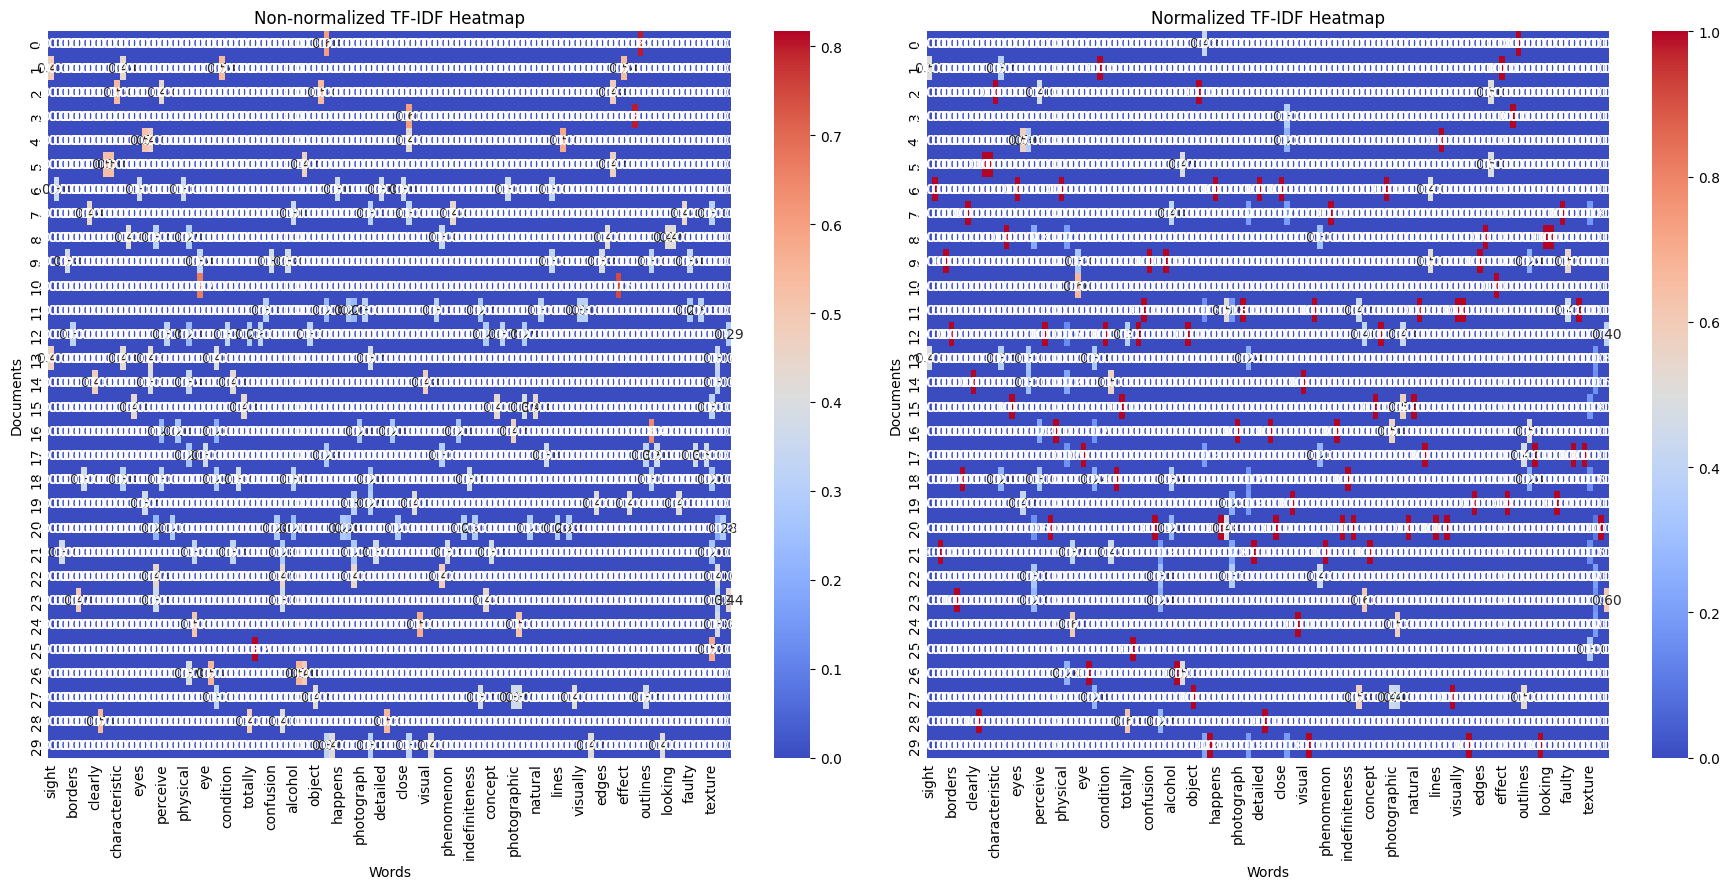

In [13]:
corpus = defs_df['astratto_specifico_blurriness'].values.tolist()

# Calculating the weighted frequencies using TF-IDF
tfidf_matrix, vocab = createIDF(corpus)

similarity = cosin_sim(tfidf_matrix[0], tfidf_matrix[1])
avg_similarity = calc_mean_similarity(tfidf_matrix, cosin_sim)

print("Avg similarity value: ", avg_similarity)

# Vocabulary
print(vocab)

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vocab)

# Create a normalized version of the DataFrame
tfidf_df_normalized = tfidf_df.div(tfidf_df.sum(axis=0), axis=1)

# Set the figure size
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Plot the non-normalized TF-IDF heatmap
sns.heatmap(tfidf_df, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Non-normalized TF-IDF Heatmap")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Documents")
axes[0].tick_params(axis='both', which='both', length=0)

# Plot the normalized TF-IDF heatmap
sns.heatmap(tfidf_df_normalized, cmap='coolwarm',
            annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Normalized TF-IDF Heatmap")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("Documents")
axes[1].tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

Come si può facilmente osservare lo spazio vettoriale generato dallo span della matrice è notevolmente **sparso**.

Di seguito valutiamo la similarità tra le definizioni di tutti e 4 i concetti:


In [14]:
# Iterate over each column in defs_df
similarity_map_idf = {}

for column in defs_df:
    # Get the values of the current column as a list
    corpus = defs_df[column].values.tolist()

    # Calculating the weighted frequencies using TF-IDF
    tfidf_matrix, vocab = createIDF(corpus)  # ,stop_words='english')

    # Calculate the similarity between the first and second rows (documents)
    similarity = calc_mean_similarity(tfidf_matrix, cosin_sim)

    similarity_map_idf[column] = similarity

    # Print the similarity value for the current column
    print(f"Similarity for column '{column}': {similarity}")

Similarity for column 'concreto_generico_door': 0.08043325590100796
Similarity for column 'concreto_specifico_ladybug': 0.2359331861778907
Similarity for column 'astratto_generico_pain': 0.08688572466953216
Similarity for column 'astratto_specifico_blurriness': 0.03256838186023693


In [15]:
similarity_map_idf

{'concreto_generico_door': 0.08043325590100796,
 'concreto_specifico_ladybug': 0.2359331861778907,
 'astratto_generico_pain': 0.08688572466953216,
 'astratto_specifico_blurriness': 0.03256838186023693}

### Visualizzazione

Visualizziamo i risultati ottenuti



In [16]:
import pandas as pd

# Convert similarity_map_idf and similarity_map_bow to pandas DataFrame
df_idf = pd.DataFrame.from_dict(similarity_map_idf, orient='index', columns=['Similarity'])
df_bow = pd.DataFrame.from_dict(similarity_map_bow, orient='index', columns=['Similarity'])

# Print similarity_map_idf in tabular format
print("Similarity Map (IDF):\n")
print(df_idf)

# Print similarity_map_bow in tabular format
print("\nSimilarity Map (BOW):\n")
print(df_bow)


Similarity Map (IDF):

                               Similarity
concreto_generico_door           0.080433
concreto_specifico_ladybug       0.235933
astratto_generico_pain           0.086886
astratto_specifico_blurriness    0.032568

Similarity Map (BOW):

                               Similarity
concreto_generico_door           0.105825
concreto_specifico_ladybug       0.363217
astratto_generico_pain           0.122411
astratto_specifico_blurriness    0.041929


## Risultati

Generalmente per i concetti "concreto-specifico", i valori di similarità ottenuti tra le definizioni, sia per IDF sia per BOW, 
risultano i più alti.

Nel caso della Similarity Map (IDF), l'approccio IDF considera le matrici sparse, che possono essere meno informative con un set di definizioni limitato. Ciò implica che le similarità ottenute utilizzando l'IDF sono relativamente basse, con valori compresi tra 0.032 e 0.236. Questi valori indicano una bassa similarità tra le definizioni considerate, ma a causa delle dimensioni ridotte del set di definizioni, non possiamo trarre conclusioni statisticamente significative sulla relazione tra i diversi concetti.

Nel caso della Similarity Map (BOW), l'approccio Bag of Words utilizza un'analisi basata sull'intersezione delle parole presenti nelle definizioni. Anche se le similarità calcolate utilizzando BOW sono leggermente più alte, con valori che arrivano anche a 0.363, la limitata estensione del set di definizioni può influire sulla significatività statistica dei risultati.

Da notare che gli approcci utilizzati, sia il Bag of Words (BOW) che l'approccio IDF, si basano esclusivamente sulla frequenza dei termini nel testo delle definizioni. Non viene considerata la semantica o il significato dei termini stessi per definire il concetto di similarità.
Pertanto, è importante tenere presente che questi approcci si limitano a considerare solo l'aspetto frequenziale dei termini senza incorporare una comprensione semantica più profonda. Per ottenere risultati di similarità più accurati e significativi, potrebbe essere necessario utilizzare approcci che tengano conto del contesto, della semantica e della struttura delle definizioni stesse.